In [81]:
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import numpy as np
np.random.seed(42)

import pandas as pd
pd.set_option('display.max_columns', None)

import ast

In [82]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id='36703fb008c44153b325eb8ed25cf24d',
    client_secret='ecbdf1b8a5684456a2fcf0baa96f53dc'))
sp.category('pop', country='US')

{'href': 'https://api.spotify.com/v1/browse/categories/pop',
 'icons': [{'height': 274,
   'url': 'https://t.scdn.co/media/derived/pop-274x274_447148649685019f5e2a03a39e78ba52_0_0_274_274.jpg',
   'width': 274}],
 'id': 'pop',
 'name': 'Pop'}

In [83]:
# sp.recommendation_genre_seeds()

In [84]:
def randotrack():
    # all available characters
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    # get random character
    randnum = np.random.randint(0,62)
    randchar = chars[randnum]
    # wildcard at beginning, end, or both?
    wildnum = np.random.randint(0,3)
    if wildnum == 0:
        return '%' + randchar
    if wildnum == 1:
        return randchar + '%'
    if wildnum == 2:
        return '%' + randchar + '%'

In [85]:
# there are a metric ton of available hip-hop tracks in the past 3 years
# more popular tracks come up first, but offset only goes to ~990 w/ limit=10
# therefore, I gotta do a random track id, with a random offset
# I'll run this many times and collect all the track info in a big list
rap = sp.search(q=f"genre:hip-hop year:2020-2021 track:{randotrack()}", market='US')

Notes:
- 'popularity' from 0-100, with higher the better. One [source](https://www.loudlab.org/blog/spotify-popularity-leverage-algorithm/) says 50 is the magic number

# let's fill out some dataframes




In [134]:
def get_tracks(tracknum=10000, limit=50, genre = 'pop'):
    sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
        client_id='CLIENT_ID',
        client_secret='CLIENT_SECRET',
        requests_timeout=50000))
    track_dict = {'id': [], 'popularity': [], 'track': [], 'artists': [], 'album_name': [],
                  'album_type': [], 'release_date': [], 'image': [], 'duration_ms': [], 
                  'preview_url': []}
    repeat_id_count = 0
    while len(track_dict['id']) < tracknum:
        search = sp.search(q=f"genre:{genre} year:2019-2021 track:{randotrack()}",
                           offset=np.random.randint(1001-limit),
                           limit=limit, market='US')
        for track in search['tracks']['items']:
            #print(" search['tracks'] keys: ", list( search['tracks'].keys()))
            if track['id'] in track_dict['id']:
                repeat_id_count += 1
                continue
            #print("Track keys: ", list(track.keys()))
            if track['preview_url'] is None:
              continue
            for col in track_dict.keys():
                if col == 'track':
                    track_dict['track'].append(track['name'])
                    continue
                if col == 'artists':
                    track_dict['artists'].append(
                        [a['name'] for a in track['artists']])
                    continue
                if col == 'album_name':
                    track_dict['album_name'].append(track['album']['name'])
                    continue
                if col == 'album_type':
                    track_dict['album_type'].append(
                        track['album']['album_type'])
                    continue
                if col == 'release_date':
                    track_dict['release_date'].append(
                        track['album']['release_date'])
                    continue
                if col == 'image':
                    try:
                        track_dict['image'].append(
                            track['album']['images'][0]['url'])
                        continue
                    except:
                        track_dict['image'].append(np.nan)
                        continue
                track_dict[col].append(track[col])
    print('Repeat ID Count:\n', repeat_id_count)
    df = pd.DataFrame(track_dict)
    df['genre'] = genre
    return df

In [135]:
tracknum = 1000
num_dfs = 200
for i in range(num_dfs):
        print(f'Data chunk #{i}...')
        get_tracks(tracknum=tracknum).to_csv(f'sample_data/track_df{i}.csv')

Data chunk #0...
Repeat ID Count:
 24
Data chunk #1...
Repeat ID Count:
 54
Data chunk #2...
Repeat ID Count:
 48
Data chunk #3...
Repeat ID Count:
 86
Data chunk #4...
Repeat ID Count:
 69
Data chunk #5...
Repeat ID Count:
 139
Data chunk #6...
Repeat ID Count:
 57
Data chunk #7...
Repeat ID Count:
 74
Data chunk #8...
Repeat ID Count:
 23
Data chunk #9...
Repeat ID Count:
 54
Data chunk #10...
Repeat ID Count:
 60
Data chunk #11...
Repeat ID Count:
 24
Data chunk #12...
Repeat ID Count:
 121
Data chunk #13...
Repeat ID Count:
 74
Data chunk #14...
Repeat ID Count:
 25
Data chunk #15...
Repeat ID Count:
 53
Data chunk #16...
Repeat ID Count:
 17
Data chunk #17...
Repeat ID Count:
 52
Data chunk #18...
Repeat ID Count:
 80
Data chunk #19...
Repeat ID Count:
 135
Data chunk #20...
Repeat ID Count:
 27
Data chunk #21...
Repeat ID Count:
 38
Data chunk #22...
Repeat ID Count:
 73
Data chunk #23...
Repeat ID Count:
 58
Data chunk #24...
Repeat ID Count:
 27
Data chunk #25...
Repeat ID Coun

In [145]:
track_df = pd.read_csv('sample_data/track_df0.csv', index_col=0)
for i in range(1,num_dfs):
    track_df = pd.concat([track_df, 
                          pd.read_csv(f'sample_data/track_df{i}.csv', index_col=0)])

In [146]:
track_df.to_csv('pop_scrape_raw.csv')

In [140]:
#ignore featured artists
track_df = track_df.drop_duplicates()
artists = [x.strip('[]').split(',')[0].strip('\'') for x in track_df['artists']]
track_df['artists'] = artists
#get artists with most songs 
song_counts = track_df.groupby('artists', as_index = False).count().sort_values('id', ascending = False)
#select artists with at least 20 songs
threshold = 20 
song_counts_filtered = song_counts[song_counts['id'] >= 15]
artists_selected = song_counts_filtered['artists'].unique()
track_df_filtered = track_df[track_df['artists'].isin(artists_selected)]
track_df_filtered_prev = track_df_filtered[~track_df_filtered['preview_url'].isna()]

In [149]:
track_df_filtered.to_csv('pop_min15songs.csv')

In [148]:
track_df_filtered.shape

(4256, 11)

In [ ]:
track_df.drop(columns='index', inplace=True)

In [ ]:
track_df['artists'] = track_df['artists'].map(lambda x: ast.literal_eval(x))

In [ ]:
track_df_expart = track_df.explode('artists')
track_df_expart

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
0,0zAeWR49IfNhtV0LLKC3wm,9,Ngày Xa Em Là Ngày Mưa Rơi (#NXELNMR),Hành OR,Tuyển Tập Của Joker Rock,single,2019-07-17,https://i.scdn.co/image/ab67616d0000b2737d9471...,244653,https://p.scdn.co/mp3-preview/7696a47b7319b2b5...
0,0zAeWR49IfNhtV0LLKC3wm,9,Ngày Xa Em Là Ngày Mưa Rơi (#NXELNMR),MC Weed,Tuyển Tập Của Joker Rock,single,2019-07-17,https://i.scdn.co/image/ab67616d0000b2737d9471...,244653,https://p.scdn.co/mp3-preview/7696a47b7319b2b5...
0,0zAeWR49IfNhtV0LLKC3wm,9,Ngày Xa Em Là Ngày Mưa Rơi (#NXELNMR),Vĩnh Hoàng,Tuyển Tập Của Joker Rock,single,2019-07-17,https://i.scdn.co/image/ab67616d0000b2737d9471...,244653,https://p.scdn.co/mp3-preview/7696a47b7319b2b5...
1,2NsAuj9pIY8GA19sfCfw6t,9,A. Xis,Xis,Seja Como For (Remasterizado),album,2020-05-20,https://i.scdn.co/image/ab67616d0000b273544965...,278760,https://p.scdn.co/mp3-preview/745ad0151e14508d...
2,7bRGtnDrBadDfoicmoPQNd,3,In God We Trust: Green Xan,Shad Da God,In God We Trust: Green Xan,single,2020-03-24,https://i.scdn.co/image/ab67616d0000b2736501d4...,189360,https://p.scdn.co/mp3-preview/6fa7111dc51c920e...
...,...,...,...,...,...,...,...,...,...,...
16706,7zEANYSbDq9RLMsIoJRZm8,32,"Espejo (feat. Jaycob Duque, Magic Q)",Ochentay7,Trap House Vol. 2,album,2020-10-20,https://i.scdn.co/image/ab67616d0000b273e66e08...,193402,https://p.scdn.co/mp3-preview/2d63a955f3f81b86...
16706,7zEANYSbDq9RLMsIoJRZm8,32,"Espejo (feat. Jaycob Duque, Magic Q)",Robot95,Trap House Vol. 2,album,2020-10-20,https://i.scdn.co/image/ab67616d0000b273e66e08...,193402,https://p.scdn.co/mp3-preview/2d63a955f3f81b86...
16706,7zEANYSbDq9RLMsIoJRZm8,32,"Espejo (feat. Jaycob Duque, Magic Q)",Neto Peña,Trap House Vol. 2,album,2020-10-20,https://i.scdn.co/image/ab67616d0000b273e66e08...,193402,https://p.scdn.co/mp3-preview/2d63a955f3f81b86...
16706,7zEANYSbDq9RLMsIoJRZm8,32,"Espejo (feat. Jaycob Duque, Magic Q)",Jaycob Duque,Trap House Vol. 2,album,2020-10-20,https://i.scdn.co/image/ab67616d0000b273e66e08...,193402,https://p.scdn.co/mp3-preview/2d63a955f3f81b86...


In [ ]:
# checking out artists for completeness of data
# really not complete at all but good enough for now. Will investigate more later
track_df_expart[track_df_expart['artists'] == 'Drake']

,id,popularity,track,artists,album_name,album_type,release_date,image,duration_ms,preview_url
127,6C9SwoZ5OrxcvkntgA5t8s,58,4pm in Calabasas,Drake,Care Package,album,2019-08-02,https://i.scdn.co/image/ab67616d0000b2739c1e02...,240217,NaN
152,6ZoZ4KGIDD23DohdVk0Ybw,55,Wants and Needs (feat. Lil Baby),Drake,Scary Hours 2,single,2021-03-05,https://i.scdn.co/image/ab67616d0000b273aeb93e...,194089,NaN
679,2Q3jFbyE61mCjS3SkW4toJ,70,Race My Mind,Drake,Certified Lover Boy,album,2021-09-03,https://i.scdn.co/image/ab67616d0000b273cd945b...,269883,NaN
950,4alHkxxwAhvoGg3dJCATKV,50,My Side,Drake,Care Package,album,2019-08-02,https://i.scdn.co/image/ab67616d0000b2739c1e02...,294650,NaN
963,2SAqBLGA283SUiwJ3xOUVI,82,Laugh Now Cry Later (feat. Lil Durk),Drake,Laugh Now Cry Later (feat. Lil Durk),single,2020-08-14,https://i.scdn.co/image/ab67616d0000b27352c75e...,261492,NaN
...,...,...,...,...,...,...,...,...,...,...
15204,6fMjgKinTRJ6CjuZKMSEiA,37,B.B. King Freestyle (with Drake),Drake,B.B. King Freestyle,single,2020-11-30,https://i.scdn.co/image/ab67616d0000b2739ecf7f...,222801,NaN
15502,65OVbaJR5O1RmwOQx0875b,83,Wants and Needs (feat. Lil Baby),Drake,Scary Hours 2,single,2021-03-05,https://i.scdn.co/image/ab67616d0000b2738b20e4...,192956,NaN
15506,3kCwyvhvVTyehIzYN2I0nF,58,Omertà,Drake,The Best In The World Pack,single,2019-06-15,https://i.scdn.co/image/ab67616d0000b2733f3b65...,219506,NaN
15741,6jy9yJfgCsMHdu2Oz4BGKX,72,Papi’s Home,Drake,Certified Lover Boy,album,2021-09-03,https://i.scdn.co/image/ab67616d0000b273cd945b...,178623,NaN


In [ ]:
# a lot of artists who I'd consider popular are below 70 on average
track_df_expart[track_df_expart['popularity'] >= 40].groupby('artists').mean()\
.sort_values('popularity', ascending=False)

,popularity,duration_ms
artists,,
Julieta Venegas,91.0,207301.0
Neo Beats,86.0,141769.0
Christian Nodal,83.0,197333.0
Empire of the Sun,79.0,234333.0
Phonk,78.0,150941.0
...,...,...
TK Kravitz,40.0,147986.0
Yungster Jack,40.0,107941.0
A.C.O,40.0,262250.0


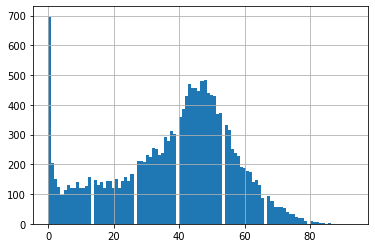

In [ ]:
'''
40 or higher seems to be a decent cutoff
will select the cutoff after the train-test-holdout split though to
keep data leakage at a minimum
'''
track_df['popularity'].hist(bins=100)

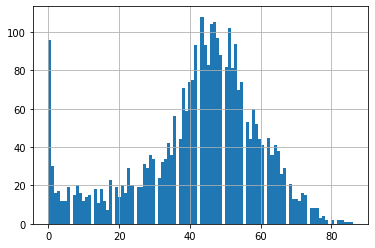

In [ ]:
# songs without mp3s skew slightly more popular
track_df[track_df['preview_url'].isna()]['popularity'].hist(bins=100)

In [ ]:
# Drop duplicate preview mp3s
mp3s = track_df.drop_duplicates(subset=['preview_url'])
mp3s = mp3s.dropna(subset=['preview_url'])

In [ ]:
mp3s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12938 entries, 0 to 16706
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            12938 non-null  object
 1   popularity    12938 non-null  int64 
 2   track         12938 non-null  object
 3   artists       12938 non-null  object
 4   album_name    12938 non-null  object
 5   album_type    12938 non-null  object
 6   release_date  12938 non-null  object
 7   image         12937 non-null  object
 8   duration_ms   12938 non-null  int64 
 9   preview_url   12938 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.1+ MB


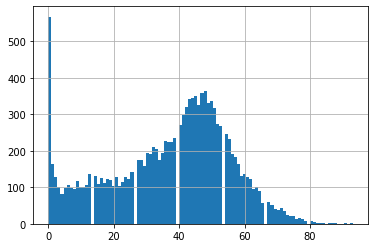

In [ ]:
mp3s['popularity'].hist(bins=100)

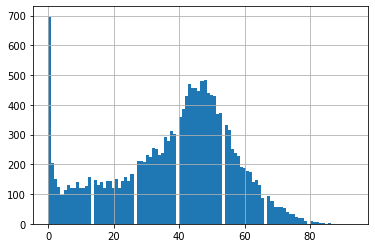

In [ ]:
# songs with preview mp3s and all unique songs collected are distributed about the same
# (despite the above thing being true about no mp3 songs)
track_df['popularity'].hist(bins=100)

In [ ]:
mp3s.to_csv('sample_data/collection_1_mp3s.csv')

### Stuff with Spotify's audio analysis, will come back to later

In [ ]:
KC = sp.search(q=f"artist:KC Makes Music", market='US')

In [ ]:
KC['tracks']['items'][0]['id']

In [ ]:
sp.audio_features('3W3cS8fgzXc2PcWtywV2gQ')

In [ ]:
sp.audio_analysis('3W3cS8fgzXc2PcWtywV2gQ').keys()

In [ ]:
sp.audio_analysis('3W3cS8fgzXc2PcWtywV2gQ')['track']

In [ ]:
track_df.loc[0,'id']

In [ ]:
sp.audio_features(track_df.loc[0,'id'])[0]

In [ ]:
audio_features_keys

Audio analysis and audio features dataframe
- sample rate = `num_samples`/`duration` = 22050 samples/sec 
- `analysis_channels` = 1, mono sound

In [ ]:
list(sp.audio_features(track_df.loc[0,'id'])[0].keys())

In [ ]:
audio_analysis_keys = ['num_samples','duration',
                       'analysis_sample_rate','end_of_fade_in',
                       'start_of_fade_out','tempo','tempo_confidence','time_signature',
                       'time_signature_confidence','key','key_confidence','mode','mode_confidence']
audio_features_keys = ['loudness','danceability','energy','speechiness',
                       'acousticness','instrumentalness','liveness','valence']
audio_df = pd.DataFrame(columns=['id', *audio_analysis_keys, *audio_features_keys])
audio_df['id'] = track_df['id'].copy()

for track in audio_df['id']:
    analysis = sp.audio_analysis(track)['track']
    features = sp.audio_features(track)[0]
    
    for col in audio_analysis_keys:
        audio_df.loc[audio_df['id'] == track, col] = analysis[col]
    for col in audio_features_keys:
        audio_df.loc[audio_df['id'] == track, col] = features[col]

audio_df

In [ ]:
audio_df.iloc[:,1:].applymap(int).describe()

In [ ]:
list(audio_df.loc[:10,'id'].values)